### Model

In [1]:
import libs.forward_model as fm
import libs.read_data as rd
import libs.visualizer as vs
import torch

    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Parameter Definition
NA = 1.2
Rindex= 1.5
lambda_= 532.0/ 1000 #um
dx, dy, dz= 1/3,1/3,1. #um
ep_dx, ep_dy =2,2
Nx,Ny,Nz = 30,30,21
m = 20
down_factor = 0.5


fm.init_parameters(NA_=NA, Rindex_=Rindex, lambda_=lambda_, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz)
fm.init_DMD_patterns(m, ep_dx__=ep_dx, ep_dy__=ep_dy)
rd.init_parameters(Nx,Ny,Nz,dx,dy,dz)
fm.init_one_shot(m, down_factor=down_factor,num_planes=2)

def one_shot_model(X):
    return torch.matmul(fm.A,X)

Sucessfully Initialized Point Spread Function...!!!
Sucessfully Initialized Read Data Parameters...!!!


Plane Calculations: 100%|██████████| 21/21 [05:25<00:00, 15.52s/it]

Matrix A is intialized sucessfully...!!!


## Reconstruction
$$y=A\cdot x\implies b = (A^{\tiny T}\cdot A)\cdot x\qquad where\quad b = A^{\tiny T}\cdot y$$
***Basic Solution***

$$Y = A\cdot X \implies A^{\tiny T}\cdot Y  = (A^{\tiny T}\cdot A)\cdot X\implies X = (A^{\tiny T}\cdot A)^{-1}\cdot A^{\tiny T}\cdot Y$$

***Gradient Descent Based***

$$x_0\xrightarrow{\texttt{Loss Calculation}}L =\| Ax_0 - b\|\xrightarrow{\texttt{Gradient Descent}}x_1\dots \to L=0$$ 
<!-- ------- -->

In [4]:
ATA = (fm.A.T@fm.A).float()
print("Conditional Number: ","{:.4e}".format(torch.linalg.cond(ATA)))
print(f"Rank : {torch.linalg.matrix_rank(ATA)}")

***Results***

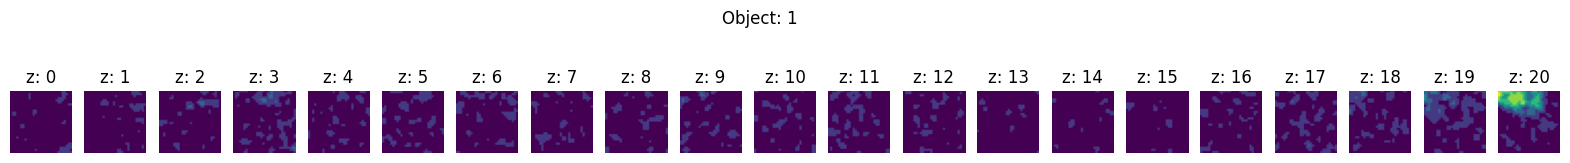

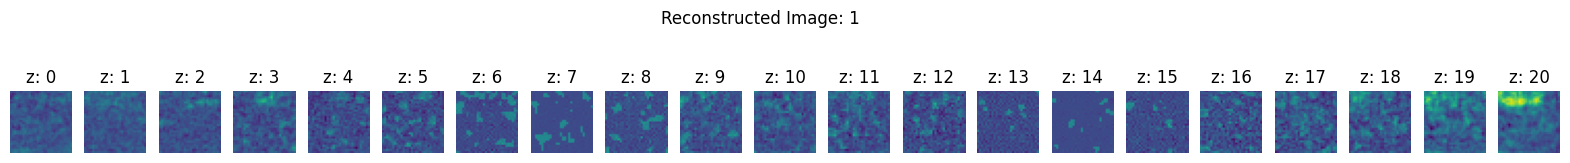

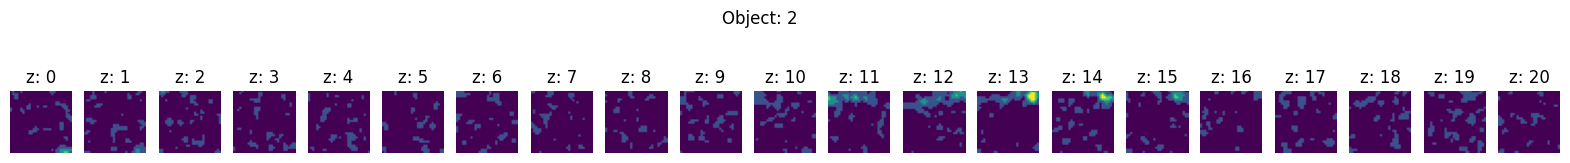

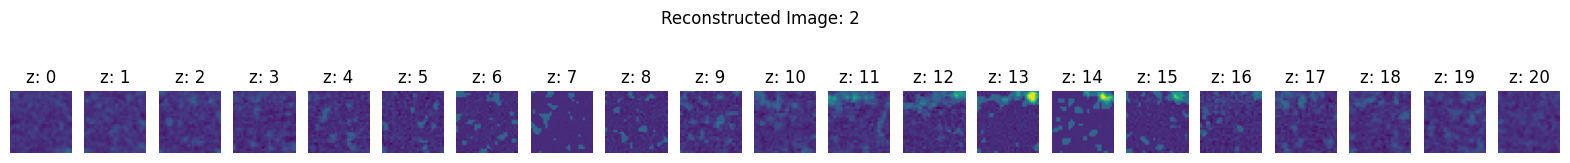

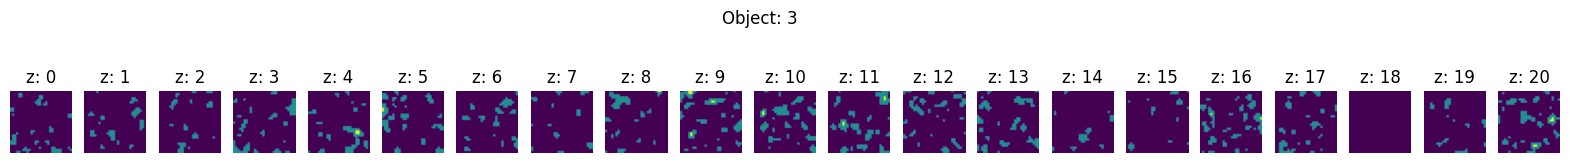

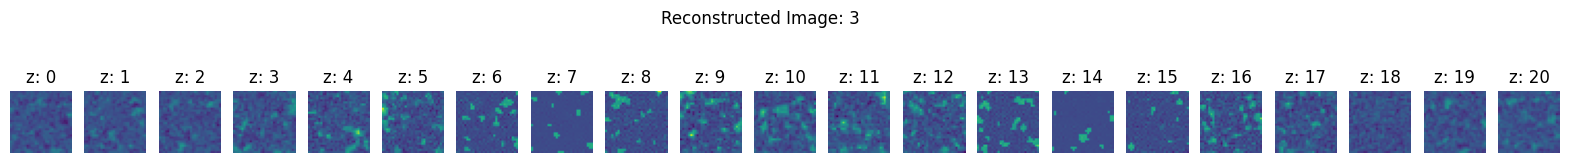

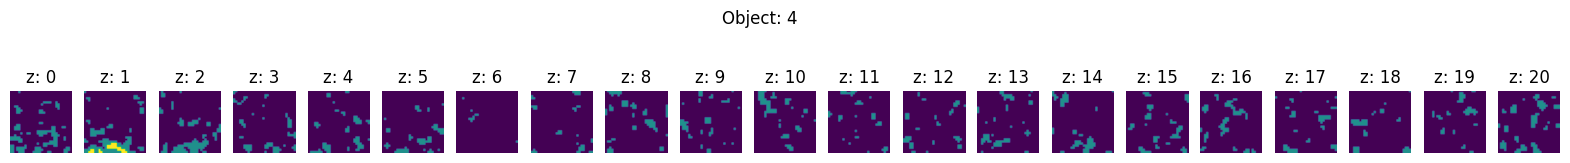

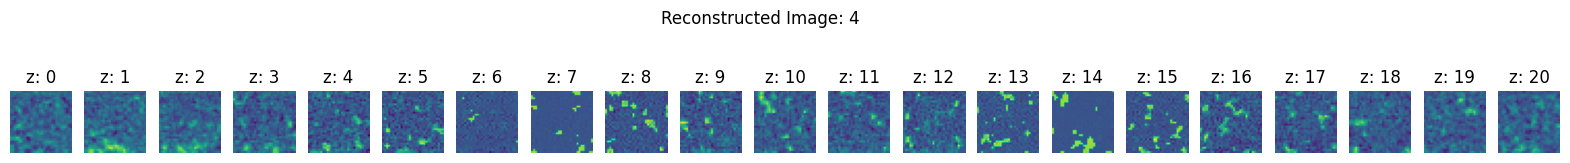

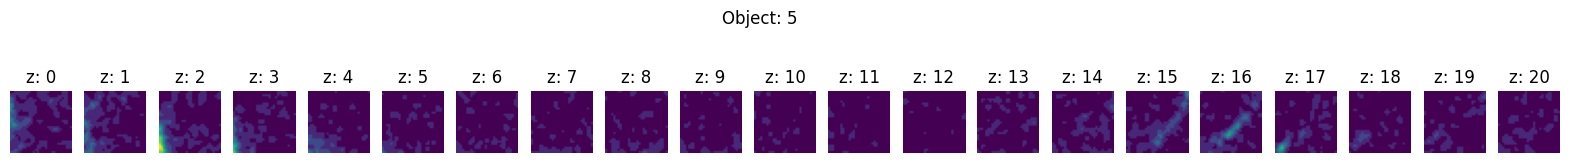

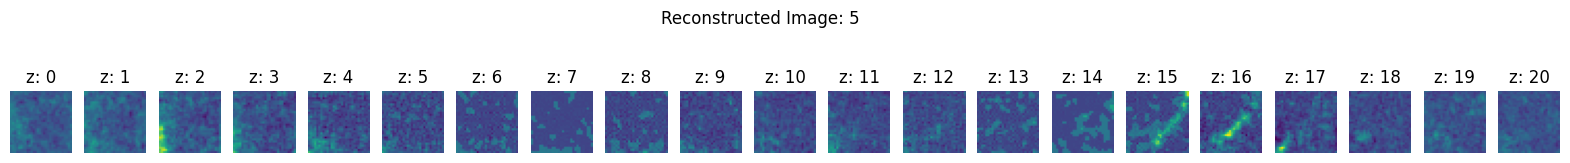

In [3]:
for c_ in range(5):
    rd.load_object("neural_cell", verbose=False)
    X_original = (rd.X).flatten()
    Y = one_shot_model(X_original)
    # X_reconstructed = reconstruct_image_gd(Y)    
    X_reconstructed = torch.linalg.lstsq(fm.A,Y).solution   
    X3D_recons = X_reconstructed.view(Nz,Nx, Ny)
    X3D_orig = X_original.view(Nz,Nx,Ny)
    vs.show_planes_z(X3D_orig.detach().cpu().numpy(),f"Object: {c_+1}",[i for i in range(Nz)])
    vs.show_planes_z(X3D_recons.detach().cpu().numpy(),f"Reconstructed Image: {c_+1}",[i for i in range(Nz)])